In [91]:
# Importing the FEM environment
from fenics import *
import numpy
%matplotlib inline
import matplotlib.pyplot as plt
# Change size of plots
fig_size = (12, 9)
plt.rcParams["figure.figsize"] = fig_size

from IPython.display import HTML
from ipywidgets import interact
# HTML(X3DOM().html(u))

# Optimization options for the form compiler
parameters["form_compiler"]["cpp_optimize"] = True
parameters['form_compiler']['cpp_optimize_flags'] = '-O3 -ffast-math -march=native'
parameters["form_compiler"]["representation"] = "uflacs"

Showing one dimensional example that the mesh needs to resolve the data variation in 
order to converge at optimal rate for the P1 finite element method.
Consider the Poisson equation, $−\nabla \cdot A \nabla u = f$ with $A(x) = (2 + cos( \frac{2 \pi x}{\epsilon} ))^{−1}$
and $f(x) = 1$, with homogeneous Dirichlet boundary conditions, where $\epsilon$  is a small parameter.
The exact solution to the problem is
$$u(x) = x - x^2 + \epsilon \left( \frac{1}{4 \pi} sin(2.0 \pi \frac{x}{\epsilon}) - \frac{1}{2 \pi} x sin(2 \pi \frac{x}{\epsilon}) - \frac{\epsilon}{4 \pi^2} cos(2 \pi \frac{x}{\epsilon}) + \frac{\epsilon}{4 \pi^2} \right) $$

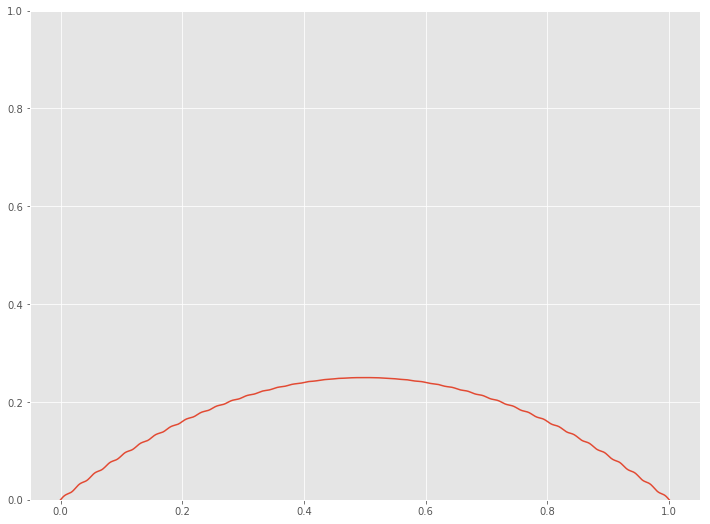

In [46]:
# Create interval of length 1
mesh = UnitIntervalMesh(1000)

# Define P1 function space
V = FunctionSpace(mesh, "Lagrange", 1)

epsilon = Constant(0.025)
A = Expression('1.0/(2.0 + cos( (2.0 * pi * x[0]) / epsilon))', degree = 2, epsilon = epsilon)

f = Constant(1.0)
bc = DirichletBC(V, Constant(0.0), "on_boundary")
u = TrialFunction(V)
v = TestFunction(V)

a = inner(A*grad(u), grad(v))*dx
L = f*v*dx

u = Function(V)
solve(a == L, u, bc)
plot(u)

In [ ]:
epsilon = Constant(0.025)
A = Expression('1.0/(2.0 + cos( (2.0 * pi * x[0]) / epsilon))', degree = 2, epsilon = epsilon)

# Choose epsilon
epsilon.assign(0.001)

# Interactive visualisation of resolving small scale features
@interact(n=(10, 1500), interval = 10)
def plot_small_scale_features(n):
    
    mesh = UnitIntervalMesh(n)
    V = FunctionSpace(mesh, "Lagrange", 1)
    f = Constant(1.0)
    bc = DirichletBC(V, Constant(0.0), "on_boundary")
    u = TrialFunction(V)
    v = TestFunction(V)

    a = inner(A*grad(u), grad(v))*dx
    L = f*v*dx
    u = Function(V)
    solve(a == L, u, bc)
    
    plt.subplot(211)
    plt.title("Projection of $A$ into function space $V$")
    plot(project(A, V))
    plt.subplot(212)
    plt.title("Solution of Poisson's problem")
    plot(u)
    plt.show()

In [63]:
# Computer L2 errors

def error_calc(h, e):

    mesh = UnitIntervalMesh(h)
    V = FunctionSpace(mesh, 'P', 1)

    f = Constant(1.0)

    bc = DirichletBC(V, Constant(0.0), "on_boundary")
    u = TrialFunction(V)
    v = TestFunction(V)

    epsilon = Constant(1)
    u_exact = Expression('x[0] - x[0]*x[0] + e*(1.0/(4.0*pi)*sin(2.0*pi*x[0]/e) - 1.0/(2.0*pi)*x[0]*sin(2.0*pi*x[0]/e) - e/(4.0*pi*pi)*cos(2.0*pi*x[0]/e) + e/(4.0*pi*pi))', e = epsilon, degree=2)
    A = Expression('1.0/(2.0 + cos( (2.0 * pi * x[0]) / epsilon))', degree = 2, epsilon = epsilon)
    epsilon.assign(e)

    a = inner(A*grad(u), grad(v))*dx
    L = f*v*dx
    
    u = Function(V)
    solve(a == L, u, bc)

    l2 = errornorm(u_exact, u, norm_type='l2')

    return l2

In [68]:
h_list = numpy.logspace(0.5, 4, dtype = 'int')
e_list = [1, 2**(-3), 2**(-6), 2**(-9), 2**(-12)]

L2_err = numpy.zeros((len(e_list), len(h_list)))

eidx = 0
for en in e_list:
    hidx = 0
    for hn in h_list:
        L2_err[eidx, hidx] = error_calc(hn, en)
        hidx += 1
    eidx += 1

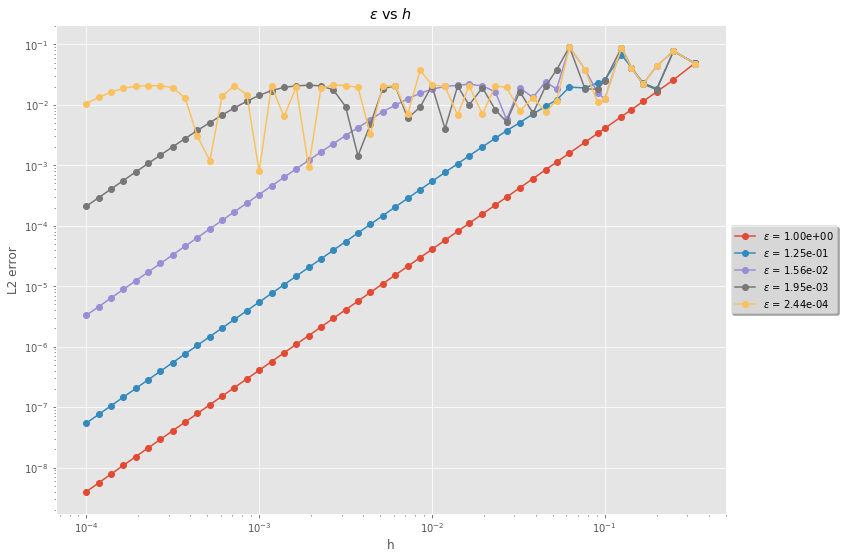

In [75]:
plt.style.use('ggplot')
for i, e in enumerate(e_list): 
    plt.loglog(1.0/h_list, L2_err[i, :], 'o-', label='$\epsilon$ = {:.2e}'.format(e))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
plt.xlabel("h")
plt.ylabel("L2 error")
plt.title("$\epsilon$ vs $h$")

It is seen from the above plot that there is the sharp transition between pre-asymptotic and the asymptotic regime and it is linked to the scale $h ≈ \epsilon$.

FEM is not capable of capturing the solution when $h>\epsilon$. One needs a mesh size of the size of the oscilations to get a proper solution, but h required may be too small.

______
It can be observed that the exact solution to the problem is composed of macroscopic part ($u_0$) and highly oscillatory microscopic part. Microscopic part tends to zero with $\epsilon$.

$u_0$ is the solution to the Poisson problem with some constant $A_0 > 0$ (the effective coefficient).
To get the error estimate for the homogenized problem start with L2-error between $u_0$ and $u_{\epsilon}$.

The error $(u_{\epsilon} - u_0) \in H_0^1(0, 1) \subset L^2(0, 1)$, so there exists a unique $z \in H_0^1(0, 1)$ such that
$$ \int_0^1 A_0 z' w' \, dx = \int_0^1 (u_{\epsilon} - u_0) w \, dx \quad \forall w \in H_0^1(0,1) $$
Choose $(u_{\epsilon} - u_0)$ as a test function, then
$$ ||u_{\epsilon} - u_0||_{L^2(0, 1)}^2 = \int_0^1 A_0 z' (u_{\epsilon} - u_0)' \, dx $$
The solutions $u_0$ and $u_{\epsilon}$ are connected by
$$A_{\epsilon} u_{\epsilon}' = A_0 u_0 \quad in H^{-1}(0, 1)$$
or,
$$ \int_0^1 A_{\epsilon} u_{\epsilon}' v \, dx = \int_0^1 A_0 u_0  v \, dx \quad \forall v \in H_0^1(0,1) $$

This leads to

$$ ||u_{\epsilon} - u_0||_{L^2(0, 1)}^2 = \int_0^1 A_0 z' (u_{\epsilon} - u_0)' \, dx =
\int_0^1 A_0 z' \frac{A_0 - A_{\epsilon}}{A_0  A_{\epsilon}} A_{\epsilon} u_{\epsilon}' \, dx =
\sum_{j=1}^N \left( \int_{(j-1)\epsilon}^{j \epsilon} \left( A_0 z' - \epsilon^{-1} \int_{(j-1)\epsilon}^{j \epsilon} A_0 z' \, dx \right) \frac{A_0 - A_{\epsilon}}{A_0  A_{\epsilon}} A_{\epsilon} u_{\epsilon}' \, dx + \epsilon^{-1} \int_{(j-1)\epsilon}^{j \epsilon} A_0 z' \, dx  \int_{(j-1)\epsilon}^{j \epsilon} \frac{A_0 - A_{\epsilon}}{A_0  A_{\epsilon}} \left(A_{\epsilon} u_{\epsilon}' - \epsilon^{-1} \int_{(j-1)\epsilon}^{j \epsilon} A_{\epsilon} u_{\epsilon}' \, dx \right)\, dx + \epsilon^{-2} \int_{(j-1)\epsilon}^{j \epsilon} A_0 z' \, dx \int_{(j-1)\epsilon}^{j \epsilon} \frac{A_0 - A_{\epsilon}}{A_0  A_{\epsilon}} \, dx  \int_{(j-1)\epsilon}^{j \epsilon} A_{\epsilon} u_{\epsilon}' \, dx \right) $$

Integrals were devided into integrals over periods of the coefficients and subtracted and added means values of functions on these periods. Then by Cauchy-Schwarz and the Poincare inequality:
$$ ||u_{\epsilon} - u_0||_{L^2(0, 1)}^2 \leq \epsilon \pi^{-1} \sum_{j=1}^N  \left( \left\vert\left\vert \frac{A_0 - A_{\epsilon}}{A_0 A_{\epsilon}} \right\vert\right\vert_{L^\infty ((j-1) \epsilon, j \epsilon)} ||A_0 z''||_{L^2 ((j-1) \epsilon, j \epsilon)} ||A_{\epsilon} u_{\epsilon}'||_{L^2 ((j-1) \epsilon, j \epsilon)} + \left\vert\left\vert \frac{A_0 - A_{\epsilon}}{A_0 A_{\epsilon}} \right\vert\right\vert_{L^\infty ((j-1) \epsilon, j \epsilon)} ||A_0 z'||_{L^2 ((j-1) \epsilon, j \epsilon)} ||(A_{\epsilon} u_{\epsilon}')'||_{L^2 ((j-1) \epsilon, j \epsilon)} \right) + \epsilon^{-2} \sum_{j=1}^N \left( \int_{(j-1)\epsilon}^{j \epsilon} A_0 z' \, dx \int_{(j-1)\epsilon}^{j \epsilon} \frac{A_0 - A_{\epsilon}}{A_0  A_{\epsilon}} \, dx  \int_{(j-1)\epsilon}^{j \epsilon} A_{\epsilon} u_{\epsilon}' \, dx \right)$$

The third terms on RHS tends to zero as $\epsilon \to 0$ iff it is actually zero. This is achieved by the unique choice 
$$A_0 = \left( \epsilon^{-1} \int_{(j-1)\epsilon}^{j \epsilon} A_{\epsilon}^{-1} \, dx \right)^{-1} = \left( \int_0^1 A_{\epsilon}^{-1} \, dx \right)^{-1}$$

Thus the error estimate is now:

$$ ||u_{\epsilon} - u_0||_{L^2(0, 1)}^2 \leq \epsilon \pi^{-1}  \left( \left\vert\left\vert \frac{A_0 - A_{\epsilon}}{A_0 A_{\epsilon}} \right\vert\right\vert_{L^\infty ((j-1) \epsilon, j \epsilon)} ||A_0 z''||_{L^2 (0,1)} ||A_{\epsilon} u_{\epsilon}'||_{L^2 (0,1)} + \left\vert\left\vert \frac{A_0 - A_{\epsilon}}{A_0 A_{\epsilon}} \right\vert\right\vert_{L^\infty ((j-1) \epsilon, j \epsilon)} ||A_0 z'||_{L^2 (0,1)} ||(A_{\epsilon} u_{\epsilon}')'||_{L^2 (0,1)} \right)$$

As $$ -A_0 z'' = u_{\epsilon} - u_0 \quad \mbox{in} \, L^2(0,1) $$
$$||A_0 z'||_{L^2(0,1)} \leq \pi^{-1} || u_{\epsilon} - u_0 ||_{L^2(0,1)}$$
$$-(A_{\epsilon}u_{\epsilon}')' = f \quad \mbox{in} \, L^2(0,1)$$
$$||A_{\epsilon}u_{\epsilon}'||_{L^2(0,1)} \leq \pi^{-1} \sqrt{\frac{\beta}{\alpha}} ||f||_{L^2(0,1)} $$
with $\alpha := \mbox{inf}_{0<x<1} A_1(x)>0$ and $\beta := \mbox{sup}_{0<x<1}A_1(x) \geq \alpha$, finally the error estimate is

$$||u_{\epsilon} - u_0||_{L^2(0, 1)}^2 \leq \epsilon \frac{2}{\alpha \pi} \left(1 + \sqrt{\frac{\beta}{\alpha}} \right) ||f||_{L^2(0,1)} $$
____
The corresponding macroscopic solution approximates the true solution $u_{\epsilon}$ with an accuracy proportional to $\epsilon$ in $L^2(0,1)$.

For P1 finite elements the  error estimate for numerical approximation $u_{0,h}$ is 
$$||u_{\epsilon} - u_{0,h}||_{L^2(0, 1)}^2 \leq \frac{1}{A_0 \pi^2} H^2 ||f||_{L^2(0,1)} $$
$H$ is the mesh size.

Hence, for a given fixed value of $\epsilon$, a finite element computation on the discretization scale $H = \sqrt{\epsilon}$ would yield an approximation of the macroscopic part of $u_{\epsilon}$ on the same order of accuracy as $u_0$ itself.
This is shown in the plots below.

Effective coefficient in 1D is equal to $A_0 = \left( \int_0^1 A_{\epsilon}^{-1} \, dx \right)^{-1}$

In [99]:
# Compute effective coefficient
epsilon = Constant(0.01)
A = Expression('1.0/(2.0 + cos( (2.0 * pi * x[0]) / epsilon))', degree = 2, epsilon = epsilon)

mesh = UnitIntervalMesh(1000)
A_0 = 1/assemble( (1/A)*dx(mesh) )
print(A_0)

0.5000190428726783


In [100]:
import scipy.integrate as integrate
def integrand(x):
    return 1.0 / (1.0/(2.0 + cos( (2.0 * pi * x) / e)))
e_list = [1, 2**(-3), 2**(-6), 2**(-9), 2**(-12)]
for e in e_list:
    print(1/integrate.quad(integrand, 0, 1)[0])

0.5
0.5000000000000001
0.49999999999999956
0.463779125262623
0.4675174954791627


/usr/lib/python3/dist-packages/scipy/integrate/quadpack.py:357: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [101]:
import sympy
x = sympy.Symbol('x')
for e in e_list:
    print(1/sympy.integrals.integrate(1.0 / (1.0/(2.0 + sympy.cos( (2.0 * pi * x) / e))), (x, 0, 1)))

0.500000000000000
0.500000000000000
0.500000000000000
0.500000000000000
0.500000000000000


A_0 is equal to 0.5 for the given problem

In [102]:
# Computer L2 errors of homogenised problem

def error_calc(h, e):

    mesh = UnitIntervalMesh(h)
    V = FunctionSpace(mesh, 'P', 1)

    f = Constant(1.0)

    bc = DirichletBC(V, Constant(0.0), "on_boundary")
    u = TrialFunction(V)
    v = TestFunction(V)

    epsilon = Constant(1)
    u_exact = Expression('x[0] - x[0]*x[0] + e*(1.0/(4.0*pi)*sin(2.0*pi*x[0]/e) - 1.0/(2.0*pi)*x[0]*sin(2.0*pi*x[0]/e) - e/(4.0*pi*pi)*cos(2.0*pi*x[0]/e) + e/(4.0*pi*pi))', e = epsilon, degree=2)
    u_0 = Expression('x[0] - x[0]*x[0]', degree = 2)
    epsilon.assign(e)

    A_0 = Constant(0.5)

    a = inner(A_0*grad(u), grad(v))*dx
    L = f*v*dx
    
    u = Function(V)
    solve(a == L, u, bc)

    l2_u0 = errornorm(u_0, u, norm_type='l2')
    l2_ue = errornorm(u_exact, u, norm_type='l2')

    return l2_u0, l2_ue

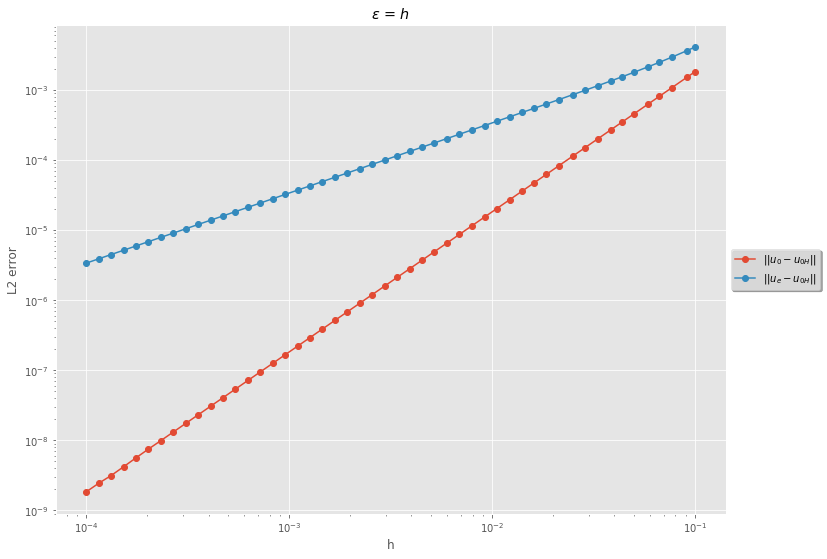

In [103]:
h_list = numpy.logspace(1, 4, dtype = 'int')

L2_err1 = numpy.zeros(len(h_list))
L2_err2 = numpy.zeros(len(h_list))

eidx = 0
for en in e_list:
    hidx = 0
    for hn in h_list:
        L2_err1[hidx], L2_err2[hidx] = error_calc(hn, 1/hn)
        hidx += 1
    eidx += 1

plt.style.use('ggplot')
#for i, e in enumerate(e_list): 
plt.loglog(1.0/h_list, L2_err1, 'o-', label='$||u_0 - u_{0H}||$')
plt.loglog(1.0/h_list, L2_err2, 'o-', label='$||u_e - u_{0H}||$')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
plt.xlabel("h")
plt.ylabel("L2 error")
plt.title("$\epsilon$ = $h$")

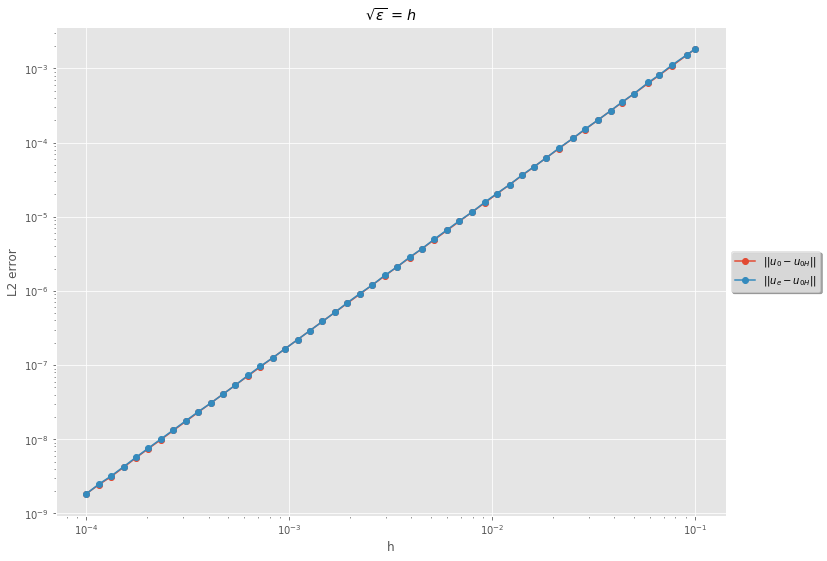

In [104]:
h_list = numpy.logspace(1, 4, dtype = 'int')

L2_err1 = numpy.zeros(len(h_list))
L2_err2 = numpy.zeros(len(h_list))

eidx = 0
for en in e_list:
    hidx = 0
    for hn in h_list:
        L2_err1[hidx], L2_err2[hidx] = error_calc(hn, (1/hn)**2)
        hidx += 1
    eidx += 1

plt.style.use('ggplot')
#for i, e in enumerate(e_list): 
plt.loglog(1.0/h_list, L2_err1, 'o-', label='$||u_0 - u_{0H}||$')
plt.loglog(1.0/h_list, L2_err2, 'o-', label='$||u_e - u_{0H}||$')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
plt.xlabel("h")
plt.ylabel("L2 error")
plt.title("$\sqrt{\epsilon}$ = $h$")

This was analytical periodic homogenization. Next step numerical homogenization for rough (not periodic) coefficients ?